# Tarea 2: árbol de regresión
##### Por: Daniela Flores Villanueva


## Importación de librerías

Antes de comenzar con la implementación del árbol y todo lo relacionado a él, se deben importar las siguientes librerías:

- `pandas`: utilizada para cargar la base de datos y para realizar las divisiones de los datos en los nodos de manera sencilla. También se usa para poder predecir por sobre todo el conjunto de prueba de forma sencilla.
- `numpy`: se usa para realizar operaciones sencillas sobre elementos de un vector.
- `scipy`: librería que resenta una función para minimizar (`scipy.optimize.fminbound`) una función acotada. Los detalles del porqué de su utilización se revisarán más adelante.
- `time`: librería usada en esta tarea para medir el tiempo de *fitting* del árbol. 
- `pygraphviz`: esta librería se utiliza para visualizar el árbol de regresión.

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import optimize
import time
import pygraphviz as pgv
import pickle
from IPython.display import Image

## Breve exploración de los datos

Tras cargar los datos, conviene revisar cómo luce la base de datos y conocer algunas medidas de tendencia central. Esto cobrará relevancia para cuando se realicen las divisiones en los nodos del árbol. Así, la tabla de *describe* a permite revisar si los valores de corte corresponden.

In [13]:
dataframe = pd.read_csv("./FATS_GAIA.dat")
dataframe = dataframe.drop(["Class", "ID"], axis=1)
display(dataframe.head())
display(dataframe.describe())

,Amplitude,AndersonDarling,Autocor_length,Con,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,...,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std
0,1.416432,0.949482,3.0,0.000000,5.442293,0.243054,0.462373,0.653511,0.761790,0.924793,...,268.331543,0.025528,0.304804,0.310355,1.784879,0.304804,0.011895,19.899170,-1.266215,0.931676
1,0.443386,1.000000,1.0,0.000000,12042.752633,0.162446,0.231268,0.517775,0.720122,0.836798,...,0.508910,0.012390,0.309458,0.519645,0.397205,0.258203,-0.962335,0.147949,-0.183573,0.284637
2,0.170099,0.875986,4.0,0.030303,137.020266,0.033964,0.208724,0.378623,0.501416,0.869956,...,8.742769,0.040022,0.342646,0.700200,0.119849,0.368936,0.472161,0.147949,0.064528,0.089020
3,1.350858,0.999869,4.0,0.000000,23.583559,0.259476,0.593270,0.613808,0.817245,0.943033,...,379.949707,0.000843,0.349687,0.285682,1.867060,0.349687,-0.047072,23.597900,-1.454570,0.926506
4,0.248472,0.999947,3.0,0.000000,125.486491,0.202240,0.448444,0.565120,0.606539,0.840512,...,318.427795,0.022169,0.247451,0.578087,0.273482,0.247451,0.594605,0.147949,-0.689124,0.153349


,Amplitude,AndersonDarling,Autocor_length,Con,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,...,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std
count,200669.000000,200669.000000,200669.000000,200669.000000,2.006690e+05,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,...,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000,200669.000000
mean,0.356194,0.937302,2.062222,0.001212,2.896656e+04,0.206497,0.355241,0.512039,0.673282,0.860889,...,105.908304,0.295930,0.306698,0.692520,0.341860,0.261966,-0.188278,5.873083,-0.347837,0.221497
std,0.271711,0.142073,1.580630,0.007241,3.304878e+06,0.112091,0.142606,0.151633,0.143211,0.103530,...,276.866335,0.353350,0.059720,0.376351,0.313569,0.094387,0.604255,9.716280,1.148951,0.178211
min,0.050792,0.110900,1.000000,0.000000,3.890648e-01,0.001687,0.003167,0.006041,0.012819,0.088982,...,0.054367,0.000000,0.132645,0.010864,0.007683,0.029167,-4.447674,0.073853,-2.033755,0.025378
25%,0.186093,0.963348,1.000000,0.000000,1.778100e+02,0.124237,0.255463,0.412196,0.582512,0.807681,...,0.578927,0.008208,0.261232,0.406622,0.164543,0.184958,-0.596010,0.073975,-1.070604,0.114993
50%,0.278772,0.998826,1.000000,0.000000,8.002217e+03,0.192851,0.348425,0.513206,0.682317,0.884673,...,1.354600,0.112397,0.297755,0.623076,0.266075,0.250375,-0.230997,0.147949,-0.630011,0.170875
75%,0.422388,0.999993,3.000000,0.000000,3.100896e+04,0.271943,0.447524,0.615310,0.778957,0.939349,...,34.990252,0.533712,0.345839,0.910716,0.385042,0.339093,0.169635,11.909912,0.030549,0.256888
max,3.452071,1.000000,34.000000,0.125000,1.459391e+09,0.912962,0.969089,0.981342,0.994295,0.999801,...,4007.871094,1.000000,0.496244,3.019829,3.143382,0.496244,4.415321,135.817383,26.480636,1.747553


## Preprocesamiento: dividir base de datos en *train* y *test*

Para tener datos sobre los cuales probar el árbol, se debe separar la base de datos en entrenamiento y prueba. La proporción utilizada corresponde a 80% de entrenamiento y 20% de prueba.

In [3]:
train = dataframe.sample(frac=0.8, random_state=7).reset_index()
train = train.drop("index", 1)
test = dataframe.drop(train.index).reset_index()
test = test.drop("index", 1)

Para trabajar con mayor facilidad en el árbol, se dividirán los datos en un DataFrame con las variables predictoras (X) y una Series con los valores de la variable a predecir (y). En este caso, la variable a predecir corresponde a `PeriodLS`.

In [4]:
X_train = train[[column for column in train.columns if column != "PeriodLS"]]
y_train = train["PeriodLS"]
X_test = test[[column for column in train.columns if column != "PeriodLS"]]
y_test = test["PeriodLS"]

## Construcción del árbol

## Construcción del nodo

La siguiente celda permite construir un nodo del futuro árbol de regresión. Sus atributos son los siguientes:

- `X`: filas de datos del nodo con las variables predictoras.
- `y`: filas de datos del nodo que corresponden a los valores de la variable que se desea predecir
- `parent`: padre del nodo.
- `id`: id del nodo.
- `left`: hijo izquierdo del nodo.
- `right`: hijo derecho del nodo.
- `split_label`: variable por la que se dividió el nodo.
- `split_value`: valor de la variable por la que se dividió el nodo.

Antes de describir los métodos de la clase, es conveniente revisar la siguiente fórmula, que aparece en el texto "Classification and regression trees" de Leo Breiman:

![title](variance_reduction.svg)

La fórmula anterior corresponde a la reducción de varianza del nodo $N$. Reducir esto es análogo a cuando en un árbol de decisión se busca reducir la entropía del nodo. Este fue el primer criterio que se probó para decidir en qué variable y en qué valor de ella basarse para realizar el *split* del nodo.

Los métodos encapsulados en esta clase son los siguientes:

- `find_best_split`: esta función intenta minimizar de manera manual el valor de la varianza en cada *split*. Esto por que una reducción de la varianza más grande implica una mayor calidad de la división del nodo. Para decidir en qué variable conviene realizar el *split* y en qué valor hacerlo, se itera por sobre cada una de las *features* posibles. En cada feature, se intenta realizar un *split* por cada valor único que presentan los datos sobre ella. Se elige el valor de *split* que maximiza la reducción de la varianza como representante de la característica. Cuando se tienen los mejores valores de *split* de cada *feature*, se procede a decidir cuál de todas las variables presenta mayor reducción de la varianza. Esa será la variable por la cuál se realizará la división del nodo en un hijo izquierdo y uno derecho. El valor para realizar el corte corresponde a aquel que, en la *feature*, presenta una mayor reducción de la varianza. Lamentablemente, esta forma "naïve" se demora demasiado: tras una hora de ejecución, el método no fue capaz de arrojar un mejor *split* ni siquiera para una variable. Por esa razón se decidió probar otra alternativa. Se conservó de todas formas el código, para demostrar que se probaron varias alternativas.

- `split_node`: función que retorna los datos correspondientes al lado izquierdo ($\leq$) y al derecho ($>$) según el valor con el que se quiere probar el *split*.

- `var_red_function`: método estático que corresponde que calcula la reducción de varianza para un *split* dado. La utilidad de esta función se explicará más adelante. Solo se enfoca en el segundo término de la fórmula de $I_{V}(N)$ mostrada, pues es este el término que, si se hace más pequeño, aumenta la reducción de la varianza, que es lo que se busca para obtener un buen *split*.

- `calculate_rss`: método estático que corresponde a una función que calcula la suma de cuadrados residuales para un arreglo. La utilidad de esta función se explicará más adelante.

- `rss_function`: método estático que calcula la suma de cuadrados residuales para un *split* dado. La utilidad de esta función se explicará más adelante.

- `find_split_with_scipy`: tras descubrir que buscar el mejor split con la forma "manual" descrita en `find_best_split` era una idea terrible y que quizás no alcanzaba a terminar de ejecutarse antes del plazo de entrega de la tarea, se decidió adoptar un enfoque de optimización. Lo que se busca minimizar, según el libro antes citado, es el segundo término de la fórmula expuesta más arriba, pues si se hace pequeño, la reducción de varianza se hace más grande, que es justamente lo que se desea. Otra forma de decidir el *split*, también obtenida de la literatura, es minimizar la suma de cuadrados residuales. Con estas ideas en mente, se decidió indagar sobre "optimizadores" en Python y se llegó a que una opción sencilla es usar `scipy`: se sabe que si una variable tiene $n$ valores posibles, hay $n$ posibles *splits*, cuyo dominio va entre el mínimo valor posible de la variable y el máximo. Así, es posible utilizar `scipy.optimize.fminbound` para encontrar el mínimo de una función acotada por dos valores, que, en este caso, corresponderían al mínimo y el máximo. La función a optimizar es decidida por el usuario, quien puede elegir entre suma de cuadrados residuales ("rss") o reducción de varianza ("var_red"). Se dan las dos opciones pues en ocasiones arrojan resultados distintos. Esta opción se entrega como parámetro en el árbol de regresión, que será definido más adelante. Así, se elige la feature que presente el *split* que reduzca más la varianza o bien, que reduzca la suma de cuadrados residuales.

In [5]:
class Node:
    id_count = 0

    def __init__(self, X, y, parent=None):
        self.X = X
        self.y = y
        self.parent = parent
        self.id = Node.id_count
        self.left = None
        self.right = None
        self.split_label = None
        self.split_value = None
        Node.id_count += 1

    def find_best_split(self):
        total_node_variance = self.y.var()
        features_var_red = {}
        for feature in self.X.columns:
            feature_values = self.X[feature].unique()
            values_var_red = []
            for value in feature_values:
                left_side = self.X[self.X[feature] <= value]
                right_side = self.X[self.X[feature] > value]
                left_side_var = self.y[self.y.index.isin(left_side.index)]
                right_side_var = self.y[self.y.index.isin(right_side.index)]
                final_var = total_node_variance - \
                    (left_side_var + right_side_var)
                values_var_red.append(final_var)
            max_var_red = max(values_var_red)
            features_var_red[feature] = max_var_red
        return max(features_var_red, key=features_var_red.get)

    def split_node(self):
        left_data = self.X[self.X[self.split_label] <= self.split_value]
        right_data = self.X[self.X[self.split_label] > self.split_value]
        left_target = self.y[self.y.index.isin(left_data.index)]
        right_target = self.y[self.y.index.isin(right_data.index)]
        return left_data, left_target, right_data, right_target

    @staticmethod
    def var_red_function(value, feature, X_values, y_values):
        left_side = X_values[X_values[feature] <= value]
        right_side = X_values[X_values[feature] > value]
        left_side_y = y_values[y_values.index.isin(left_side.index)]
        right_side_y = y_values[y_values.index.isin(right_side.index)]
        return len(left_side) * left_side_y.var() + len(right_side) * right_side_y.var()

    @staticmethod
    def calculate_rss(y_values):
        return np.sum((y_values - y_values.mean())**2)

    @staticmethod
    def rss_function(value, feature, X_values, y_values):
        left_side = X_values[X_values[feature] <= value]
        right_side = X_values[X_values[feature] > value]
        left_side_y = y_values[y_values.index.isin(left_side.index)]
        right_side_y = y_values[y_values.index.isin(right_side.index)]
        return Node.calculate_rss(left_side_y) + Node.calculate_rss(
            right_side_y)

    def find_split_scipy(self, mode="rss"):
        features_var_red = dict()
        for feature in self.X.columns:
            min_feature_value = self.X[feature].min()
            max_feature_value = self.X[feature].max()
            if min_feature_value == max_feature_value:
                continue
            if mode == "rss":
                optimal_split, split_var_red, ierr, numf = scipy.optimize.fminbound(
                    Node.rss_function,
                    min_feature_value,
                    max_feature_value,
                    args=(feature, self.X, self.y),
                    full_output=1)
            else:
                optimal_split, split_var_red, ierr, numf = scipy.optimize.fminbound(
                    Node.var_red_function,
                    min_feature_value,
                    max_feature_value,
                    args=(feature, self.X, self.y),
                    full_output=1)
            features_var_red[feature] = (split_var_red, optimal_split)
        best_split = sorted(features_var_red.items(), key=lambda x: x[1])[0]
        self.split_label = best_split[0]
        self.split_value = best_split[1][-1]
        return self.split_label, self.split_value

### Construcción del árbol

La clase `RegressionTree` permite construir el árbol. Sus atributos son:

- `max_depth`: profundidad máxima del árbol. Definida para que no se produzca *overfitting*.
- `min_values`: cantidad mínima de valores para que el nodo se divida.
- `optimize`: función a optimizar. Puede ser "rss" (por defecto) o "var_red".

Los métodos de esta clase son:

- `fit`: se construye el árbol a partir de los datos entregados en forma de `data` (matriz valores de variables predictoras) y `target` (arreglo de valores de la variable a predecir). Esta función es recursiva: se intenta dividir el nodo hasta que se viole uno de los criterios de detención definidos: altura máxima o cantidad de valores mínimos en el nodo. Con esto se definen los hijos izquierdo y derecho de cada nodo según el mejor *split* obtenido en cada uno.

- `predict_datum`: método estático que permite utilizar el árbol para predecir el valor de una fila de datos. Esto se logra preguntando en cada nodo si la fila cumple o no con el criterio de *split*, es decir, si para la *feature* de *split*, el valor de la *feature* en la fila es menor o igual que el valor de *split* del nodo. Si efectivamente es menor o igual, la fila se deriva al sub-árbol izquierdo, para realizar la misma pregunta en los nodos que estén en ese sub-árbol (con las *features* de *split* que tenga cada nodo en ese sub-árbol, por supuesto). En otro caso (valor de la variable mayor que el *split* del nodo), las preguntas serán realizadas a los nodos del sub-árbol derecho.

- `predict`: dado un DataFrame de datos para predecir, se retorna la prediccion para cada fila de él, mediante la utilización de `predict_datum`.

- `draw_tree`: función para realizar una visualización del árbol y sus *splits* en cada nodo. Esto se realiza gracias a `pygraphviz`.

In [6]:
class RegressionTree:
    def __init__(self, max_depth=5, min_values=40, optimize="rss"):
        self.max_depth = max_depth
        self.min_values = min_values
        self.optimize = optimize
        self.depth = 0

    def fit(self, data, target, parent=None, depth=0):
        root = Node(data, target, parent)
        if len(root.X) <= self.min_values:
            return root
        if depth >= self.max_depth:
            return root

        root.find_split_scipy(mode=self.optimize)
        left_data, left_target, right_data, right_target = root.split_node()
        root.left = self.fit(left_data, left_target, root, depth + 1)
        root.right = self.fit(right_data, right_target, root, depth + 1)
        self.root = root
        return root

    @staticmethod
    def predict_datum(root, datum):
        if root.left is None:
            return root.y.mean()
        if datum.loc[root.split_label] <= root.split_value:
            return RegressionTree.predict_datum(root.left, datum)
        return RegressionTree.predict_datum(root.right, datum)

    def predict(self, test_data):
        return test_data.apply(
            lambda x: RegressionTree.predict_datum(self.root, x), axis=1)
    
    def draw_tree(self, tree, filename):
        nodes_stack = []
        current_node = self.root
        done = False
        while not done:
            if current_node is not None:
                nodes_stack.append(current_node)
                current_node = current_node.left
            else:
                if len(nodes_stack) > 0:
                    current_node = nodes_stack.pop()
                    if current_node.split_label is not None:
                        tree.add_node(
                            current_node.id,
                            label="¿{} <= {}?".format(current_node.split_label,
                                                      current_node.split_value))
                    else:
                        tree.add_node(
                            current_node.id,
                            label="y = {}".format(current_node.y.mean()))

                    if current_node.parent is not None:
                        parent_node = current_node.parent 
                        tree.add_node(
                            parent_node.id,
                            label="¿{} <= {}?".format(parent_node.split_label,
                                                      parent_node.split_value))
                        parent = tree.get_node(parent_node.id)

                        tree.add_edge(parent, current_node.id)
                    current_node = current_node.right
                else:
                    done = True
        dot_filename = "{}.dot".format(filename)
        svg_filename = "{}.png".format(filename)
        tree.write(dot_filename)
        img = pgv.AGraph(dot_filename)
        img.layout(prog='dot')
        img.draw(svg_filename, format="png")
        img.close()        

## Métrica de evaluación

Para evaluar el desempeño del árbol de regresión, se utilizará la métrica *root mean square error* (RMSE), que corresponde a la suma de los residuos al cuadrado. Los residuos se calculan como la diferencia al cuadrado entre el valor predicho para una fila y el valor real. Un buen modelo tendrá un valor bajo para esta métrica, pues podrá entregar una predicción no muy lejana al valor real. Se decidió utilizar esta métrica porque es típica en problemas de regresión. En la celda siguiente se calcula el RMSE con la librería `numpy`.

In [7]:
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

## Pruebas sobre la base de datos entregada

Debudo a que ya se dividió los datos en conjuntos de entrenamiento y prueba, se procederá a probar el árbol de regresión anteriormente definido sobre estos conjuntos de datos. En primer lugar, se entrena el árbol (`fit`) con los datos de entrenamiento. Se imprime además el tiempo que toma este entrenamiento. En este caso, se entrenará un árbol con el criterio de reducción de la varianza.

In [8]:
tree_var_red = RegressionTree(5, 20, "var_red")
fit_start_time_var_red = time.time()
tree_var_red.fit(X_train, y_train)
fit_var_red_time = time.time() - fit_start_time_var_red
print("Training time: {} s.".format(fit_var_red_time))

406.9744188785553


Una vez entrenado el árbol, se procede a obtener las predicciones para el conjunto de prueba y a calcular el error de dichas predicciones.

In [9]:
y_pred_var_red = tree_var_red.predict(X_test)
rmse_var_red = calculate_rmse(y_pred_var_red, y_test)
print("RMSE: {}".format(rmse_var_red))

122.92839619530463


Resulta interesante comparar los resultados con un árbol entrenado con la minimización de la suma de cuadrados residuales para decidir el *split* de cada nodo.

In [ ]:
tree_rss = RegressionTree(5, 20, "rss")
fit_start_time_rss = time.time()
tree_rss.fit(X_train, y_train)
fit_rss_time = time.time() - fit_start_time_rss
print("Training time: {} s.".format(fit_rss_time))

In [ ]:
y_pred_rss = tree_rss.predict(X_test)
rmse_rss = calculate_rmse(y_pred_rss, y_test)
print("RMSE: {}".format(rmse_rss))

## Visualización del árbol

A continuación, se procede a generar una visualización del árbol. Por simplicidad, solo se hará para el árbol que utilizó el criterio "rss".

In [10]:
tree_viz = pgv.AGraph(directed=True, strict=True)
filename = "RegressionTreeRSS"
tree_rss.draw_tree(tree_viz, filename)

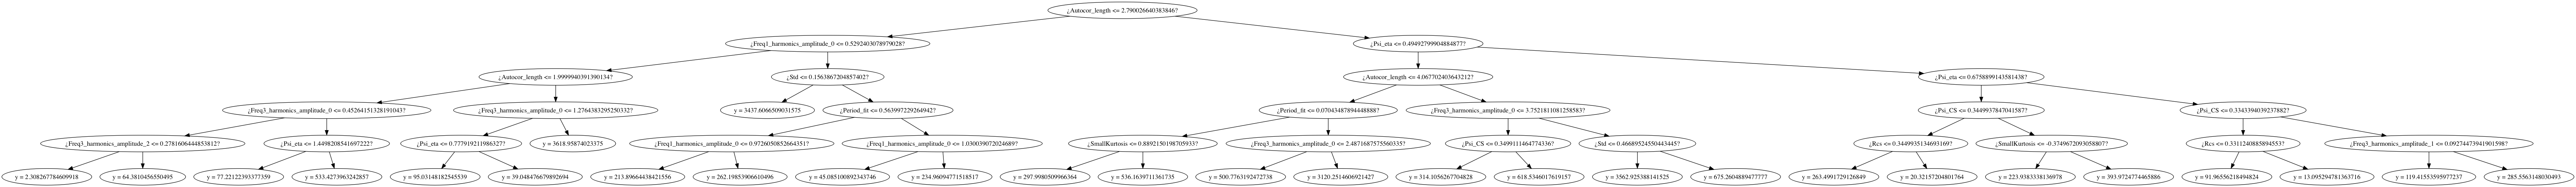

In [15]:
Image(filename="./{}.png".format(filename))